# Carbon Price Forecasting using LSTM and Transformer

## 1. Import Libraries
Import all required libraries for data loading, preprocessing, model building, and evaluation.

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import math
import torch
import torch.nn as nn
import torch.optim as optim

## 2. Device Setup and Data Loading
The dataset contains historical daily price information for the CSI300 Index.
Each record includes attributes such as `trade_date`, `open price`, `close price`, `low price`, and `high price`.
We configure TensorFlow to run on **CPU** only for stable reproducibility across different systems.

In [11]:
# Force TensorFlow to use CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Load the dataset
dataset_path = '/Users/han/Desktop/csi300.csv'
csi300_data = pd.read_csv(dataset_path)

## 3. Data Preprocessing
Take a look of the dataset then make sure `trade_date` to datetime format and sorted chronologically.
We split the dataset into **training** (before 2022-01-01) and **testing** (from 2022-01-01 onward) subsets to simulate real-world forecasting.
To ensure numerical stability, all price features are normalized between 0 and 1 using MinMaxScaler, fitted only on the training data to avoid information leakage.

In [12]:
csi300_data

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,399300.SZ,20221230,3871.6338,3873.9358,3887.5527,3868.7569,3856.7007,14.9331,0.3872,78773272.0,1.482950e+08
1,399300.SZ,20221229,3856.7007,3854.2363,3868.2933,3838.4803,3871.2644,-14.5637,-0.3762,79394815.0,1.490114e+08
2,399300.SZ,20221228,3871.2644,3874.9132,3884.7205,3854.9406,3887.8540,-16.5896,-0.4267,84424656.0,1.606711e+08
3,399300.SZ,20221227,3887.8540,3860.9054,3891.8497,3856.5800,3843.4887,44.3653,1.1543,77515350.0,1.520322e+08
4,399300.SZ,20221226,3843.4887,3830.5682,3856.8066,3827.5186,3828.2188,15.2699,0.3989,73005712.0,1.486928e+08
...,...,...,...,...,...,...,...,...,...,...,...
2425,399300.SZ,20130110,2530.5690,2525.5900,2553.3520,2513.7290,2526.1260,4.4430,0.1759,71085862.0,7.115905e+07
2426,399300.SZ,20130109,2526.1260,2518.1040,2534.2390,2504.2990,2525.3300,0.7960,0.0315,70231170.0,7.423360e+07
2427,399300.SZ,20130108,2525.3300,2534.6470,2540.5130,2502.4900,2535.9850,-10.6550,-0.4202,71837100.0,7.649806e+07
2428,399300.SZ,20130107,2535.9850,2518.0470,2545.9690,2511.6030,2524.4090,11.5760,0.4586,75167993.0,7.316751e+07


In [13]:
# Convert trade_date to datetime format
csi300_data['trade_date'] = pd.to_datetime(csi300_data['trade_date'], format='%Y%m%d')

# Sort the data by trade_date
csi300_data = csi300_data.sort_values(by='trade_date')

# Split the data: last year for testing, rest for training
test_data = csi300_data[csi300_data['trade_date'] >= '2022-01-01']
train_data = csi300_data[csi300_data['trade_date'] < '2022-01-01']

# Normalize the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['close', 'open', 'low', 'high']])
test_scaled = scaler.transform(test_data[['close', 'open', 'low', 'high']])

## 4. Sequence Construction for LSTM
Time-series data must be transformed into sequential input samples for LSTM training.
Each sequence consists of **60 consecutive trading days**, used to predict the following day’s four price values:
`open`, `close`, `low`, and `high`.

**There are several reasons for choosing 60:**

1. Quarterly market pattern: 60 trading days roughly represent three months, aligning with typical financial reporting and market cycles.
2. Balance between information and noise: shorter windows (e.g., 10 or 20 days) may lose important trend information, while very long windows (e.g., 120 or 200 days) can add noise and slow training.
3. Empirical evidence: many financial forecasting studies show that 60-day sequences provide stable convergence and effectively capture medium-term dependencies.

In practice, sequence_length is a tunable hyperparameter. You can experiment with different values such as 30, 60, or 90 to evaluate how much historical context improves prediction accuracy.

In [14]:
# Create sequences for LSTM
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]  # Predicting all prices
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 60
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 4)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(4)  # Output layer with 4 neurons for 4 prices
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/han/venvs/tf-macos311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 5. Model Training, Saving, and Evaluation
The model is trained for **50 epochs** with a **batch size of 32** using the Adam optimizer and Mean Squared Error (MSE) loss.

Similarly here, the number of epoches and batch size was determined empirically.

In [ ]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50)
# Save the model and scaler
model.save('lstm_csi300_model.h5')
scaler_filename = 'scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.5679e-04
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.4864e-04
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.4486e-04
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.3781e-04
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.6133e-04
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.0658e-04
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.5006e-04
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.8867e-04
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.9936e-04
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.6209e-04
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.2943e-04
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.1565e-04
Epoch 13/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.4506e-04
Epoch 14/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.5093e-04
Epoch 15/50
67/

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8549e-04  
Test Loss: 0.00018548699154052883


## 6. Predictions and Inverse Transformation
The trained model generates predictions on the test sequences.
Since the model output is in the normalized scale, we apply the inverse transformation of the `MinMaxScaler` to recover the **actual price values**.
This allows direct comparison between the predicted and real market data.

In [26]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


## 7. Visualization of Predictions
We visualize the predicted versus actual prices for four key variables — `close`, `open`, `low`, and `high`.
Each subplot displays one target variable, using the real trade_date values as the x-axis.
Blue lines represent actual market prices, while red lines show model predictions over the same period.

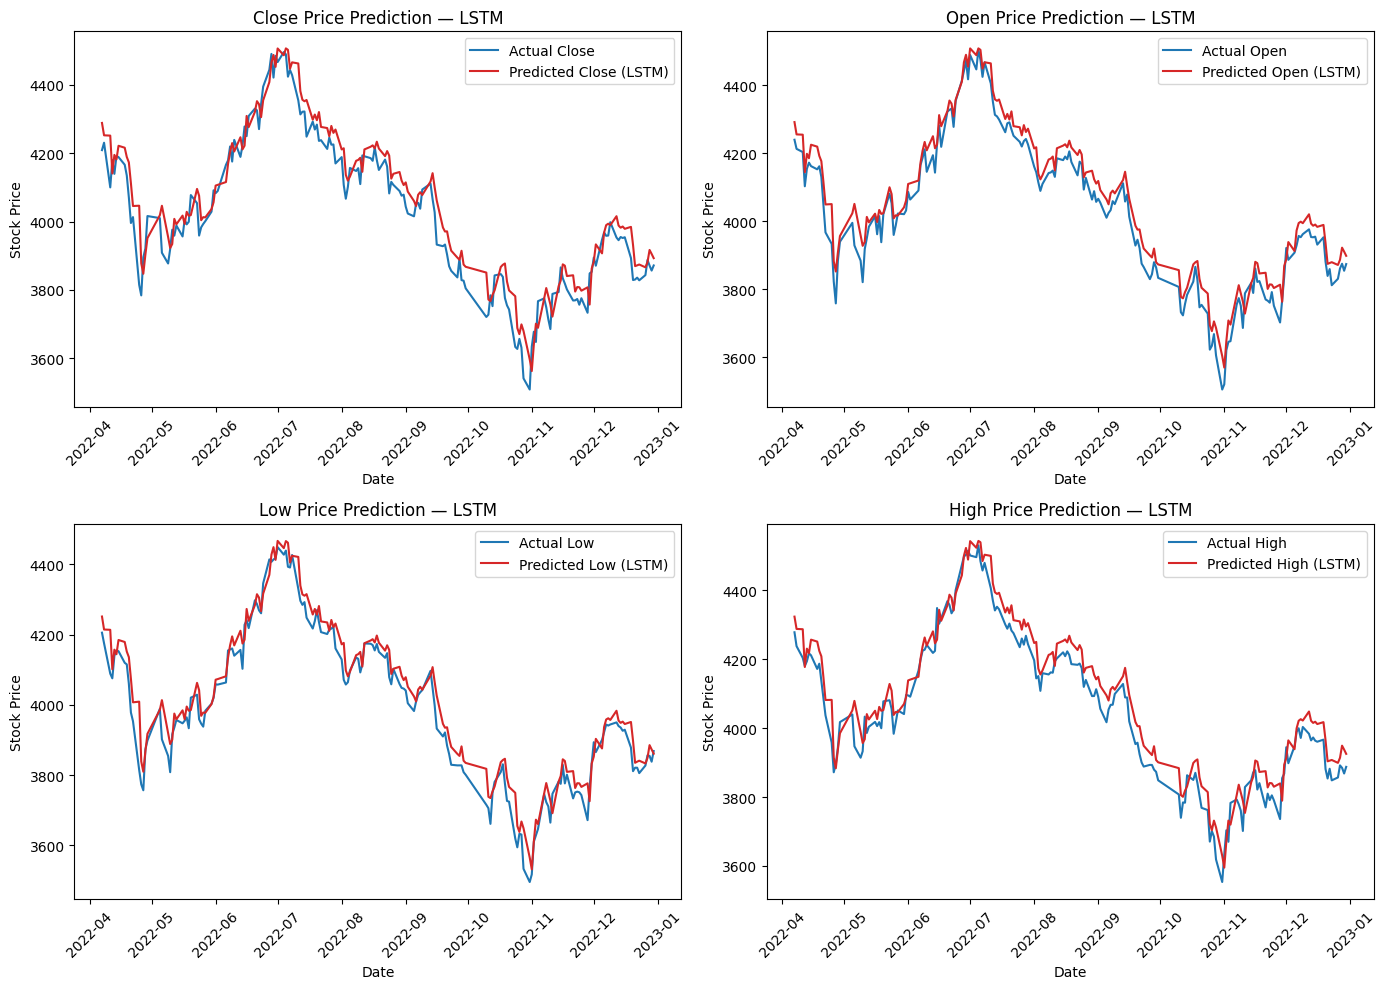

In [ ]:
cols = ['Close', 'Open', 'Low', 'High']
dates = test_data['trade_date'].iloc[sequence_length:].to_numpy()

plt.figure(figsize=(14, 10))

for i, col in enumerate(cols):
    plt.subplot(2, 2, i + 1)

    plt.plot(dates, actual[:, i], color='#1f77b4', label=f'Actual {col}', linewidth=1.5)
    plt.plot(dates, predictions[:, i], color='#d62728', label=f'Predicted {col} (LSTM)', linewidth=1.5)

    plt.title(f'{col} Price Prediction — LSTM')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()


## 8. Transformer Model Overview
This section implements a Transformer-based architecture to predict **Close, Open, Low, and High prices** simultaneously.  
The model uses the same preprocessed dataset as the LSTM model to ensure a fair comparison in terms of structure, training, and evaluation.

## 9. Data and Tensor Preparation
We reuse the arrays `X_train`, `y_train`, `X_test`, and `y_test` from the LSTM section.  
They are reshaped into tensors that match the input format required by PyTorch’s `nn.Transformer`:  
`(sequence_length, batch_size, features)`.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_np = X_train.astype(np.float32)
y_train_np = y_train.astype(np.float32)
X_test_np  = X_test.astype(np.float32)
y_test_np  = y_test.astype(np.float32)

def to_transformer_batch(x_np, y_np):
    # x_np: (N, L, 4) -> (L, N, 4)
    x_t = torch.from_numpy(x_np).transpose(0, 1).contiguous()
    y_t = torch.from_numpy(y_np)  # (N, 4)
    return x_t, y_t

X_train_t, y_train_t = to_transformer_batch(X_train_np, y_train_np)
X_test_t,  y_test_t  = to_transformer_batch(X_test_np,  y_test_np)

L = X_train_t.shape[0]     # sequence_length
E = X_train_t.shape[2]     # feature dim = 4

## 10. Positional Encoding and Model Definition
The Transformer uses self-attention to learn long-term temporal dependencies.  
We add a **positional encoding** to retain time-order information.  
The model projects input features (`close`, `open`, `low`, `high`) into a latent space, applies multiple attention layers, and outputs four predicted prices for the next day.

In [61]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(d_model)  

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(1), persistent=False)

    def forward(self, x):
        # x: (seq_len, batch_size, d_model)
        x = x * self.scale
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## 11. Masking Function for Training
The `create_masks()` function generates attention masks for the Transformer.  
The **source mask** allows all tokens to attend to each other, while the **target mask** ensures that the decoder cannot "see the future," preserving causality.

In [62]:
def create_masks(input_seq_len, tgt_seq_len):
    src_mask = torch.zeros((input_seq_len, input_seq_len), dtype=torch.bool, device=device)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(device)
    return src_mask, tgt_mask

## 12. Training Loop
This section trains the Transformer model using the Adam optimizer with a learning rate scheduler, gradient clipping, and early stopping.  
These mechanisms stabilize convergence and prevent overfitting or sudden validation-loss spikes.

In [63]:
epochs = 200
batch_size = 64
N_train = y_train_t.shape[0]

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

max_grad_norm = 1.0 
early_stop_patience = 15
best_val = float('inf')
no_improve = 0
best_state = None

def train_one_epoch():
    model_tf.train()
    idx = torch.randperm(N_train)
    total_loss, steps = 0.0, 0
    for start in range(0, N_train, batch_size):
        sel = idx[start:start+batch_size]
        src_batch = X_train_t[:, sel, :].to(device)
        y_batch   = y_train_t[sel].to(device)

        tgt_in = torch.zeros(1, src_batch.shape[1], E, device=device)
        src_mask, tgt_mask = create_masks(L, 1)

        optimizer.zero_grad(set_to_none=True)
        out = model_tf(src_batch, tgt_in, src_mask=src_mask, tgt_mask=tgt_mask)
        y_hat = out[-1]
        loss = criterion(y_hat, y_batch)
        loss.backward()

       
        torch.nn.utils.clip_grad_norm_(model_tf.parameters(), max_grad_norm)
        optimizer.step()

        total_loss += loss.item()
        steps += 1
    return total_loss / max(steps, 1)

@torch.no_grad()
def eval_on_test():
    model_tf.eval()
    src = X_test_t.to(device)
    tgt_in = torch.zeros(1, src.shape[1], E, device=device)
    src_mask, tgt_mask = create_masks(L, 1)
    out = model_tf(src, tgt_in, src_mask=src_mask, tgt_mask=tgt_mask)
    y_pred_scaled = out[-1].cpu().numpy()
    val_loss = criterion(torch.from_numpy(y_pred_scaled), y_test_t).item()
    return val_loss, y_pred_scaled

for ep in range(epochs):
    train_loss = train_one_epoch()
    val_loss, _ = eval_on_test()
    scheduler.step(val_loss) 

    if (ep + 1) % 10 == 0 or ep == 0:
        print(f"Epoch {ep+1}/{epochs} | LR: {optimizer.param_groups[0]['lr']:.2e} "
              f"| Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    if val_loss < best_val - 1e-8:
        best_val = val_loss
        no_improve = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model_tf.state_dict().items()}
    else:
        no_improve += 1
        if no_improve >= early_stop_patience:
            print(f"Early stopping at epoch {ep+1} (best val loss: {best_val:.6f})")
            break

if best_state is not None:
    model_tf.load_state_dict(best_state)


Epoch 1/200 | LR: 2.50e-04 | Train Loss: 0.000692 | Val Loss: 0.000455
Epoch 10/200 | LR: 2.50e-04 | Train Loss: 0.000596 | Val Loss: 0.000962
Epoch 20/200 | LR: 6.25e-05 | Train Loss: 0.000530 | Val Loss: 0.000362
Early stopping at epoch 21 (best val loss: 0.000202)


## 13. Model Evaluation and Inverse Transformation
After training, the model is evaluated on the test set.  
Predicted and actual values are inverse-transformed using the same `MinMaxScaler` to recover the original stock price scale, making the evaluation interpretable in real-world units.

In [64]:
val_loss, y_pred_test_scaled = eval_on_test()
y_true_test_scaled = y_test_np

y_pred_test = scaler.inverse_transform(y_pred_test_scaled)
y_true_test = scaler.inverse_transform(y_true_test_scaled)

## 14. Visualization of Predictions
We visualize the Transformer’s predictions against actual market prices.  
Each subplot corresponds to one price type (`Close`, `Open`, `Low`, `High`), using the real trading dates on the x-axis for consistency with the LSTM plots.

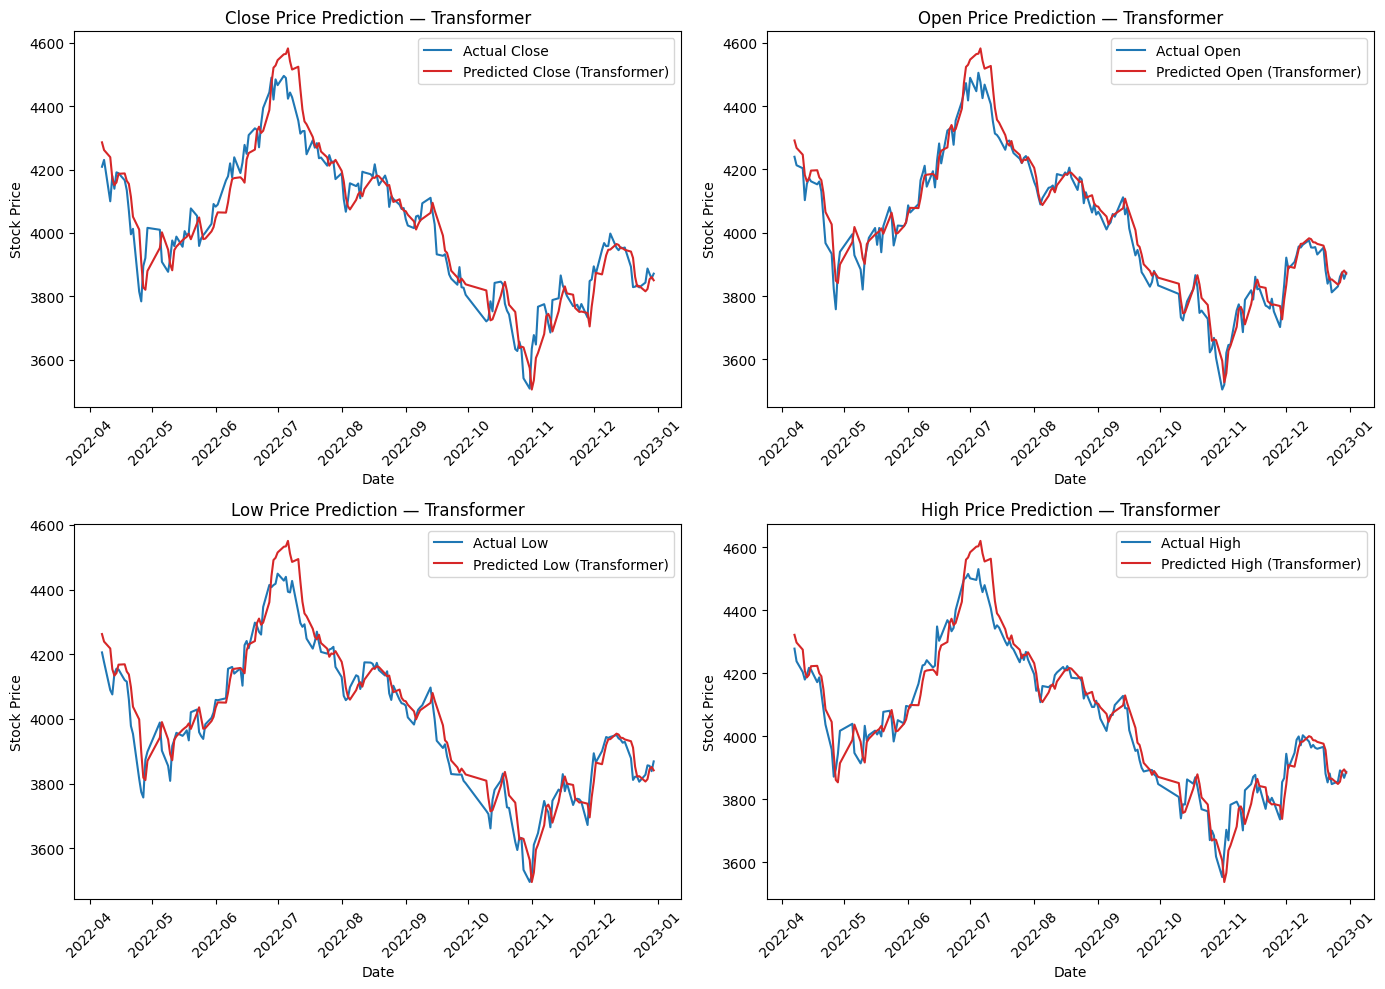

In [ ]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(cols):
    plt.subplot(2, 2, i + 1)

    plt.plot(dates, y_true_test[:, i], color='#1f77b4', label=f'Actual {col}', linewidth=1.5)
    plt.plot(dates, y_pred_test[:, i], color='#d62728', label=f'Predicted {col} (Transformer)', linewidth=1.5)

    plt.title(f'{col} Price Prediction — Transformer')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.xticks(rotation=45)
    plt.legend()

plt.tight_layout()
plt.show()

## 15. Performance Metrics
To conclude the experiment, we directly compare the **LSTM** and **Transformer** models trained on the same dataset.  
Both models predict the next-day values for **Close, Open, Low, and High prices**, using the same 60-day input window and identical normalization.

The comparison includes:  
- **MSE (Mean Squared Error)** — average squared difference between actual and predicted values.  
- **RMSE (Root Mean Squared Error)** — interpretable version of MSE in original units.  
- **R² (Coefficient of Determination)** — how well the model explains variance in the data.  
- **MAE (Mean Absolute Error)** — average absolute prediction error.

Lower MSE, RMSE, and MAE indicate better predictive accuracy, while higher R² indicates a better

In [66]:
cols = ["Close", "Open", "Low", "High"]
rows = []

for i, target in enumerate(cols):
    y_true_lstm = actual[:, i]
    y_pred_lstm = predictions[:, i]

    y_true_tf   = y_true_test[:, i]
    y_pred_tf   = y_pred_test[:, i]

    # LSTM
    mse_lstm  = mean_squared_error(y_true_lstm, y_pred_lstm)
    rmse_lstm = np.sqrt(mse_lstm)
    mae_lstm  = mean_absolute_error(y_true_lstm, y_pred_lstm)
    r2_lstm   = r2_score(y_true_lstm, y_pred_lstm)

    # Transformer
    mse_tf  = mean_squared_error(y_true_tf, y_pred_tf)
    rmse_tf = np.sqrt(mse_tf)
    mae_tf  = mean_absolute_error(y_true_tf, y_pred_tf)
    r2_tf   = r2_score(y_true_tf, y_pred_tf)

    # Collect both model results
    rows.extend([
        [target, "LSTM",        mse_lstm, rmse_lstm, mae_lstm, r2_lstm],
        [target, "Transformer", mse_tf,   rmse_tf,   mae_tf,   r2_tf]
    ])

# ====== Build and Display Comparison Table ======
df_compare = pd.DataFrame(rows, columns=["Target", "Model", "MSE", "RMSE", "MAE", "R²"])
df_compare = df_compare.round(4)

print("\n" + "="*60)
print("=== Per-Target LSTM vs Transformer Performance Comparison ===")
print("="*60)
print(df_compare.to_string(index=False))


=== Per-Target LSTM vs Transformer Performance Comparison ===
Target       Model       MSE    RMSE     MAE     R²
 Close        LSTM 3516.1444 59.2971 48.1565 0.9240
 Close Transformer 3874.0762 62.2421 47.7831 0.9163
  Open        LSTM 2226.1745 47.1824 41.1873 0.9522
  Open Transformer 2000.2513 44.7242 34.0529 0.9571
   Low        LSTM 2148.6577 46.3536 35.5482 0.9526
   Low Transformer 2959.0676 54.3973 41.7158 0.9348
  High        LSTM 2648.8153 51.4666 44.9234 0.9421
  High Transformer 2609.0378 51.0787 38.8093 0.9429


## 16. Summary and Insights
Both models achieve strong performance with R² values around 0.91–0.96 across all four price targets, indicating good generalization.
LSTM is more stable for Close and Low prices—variables dominated by smooth temporal trends—while the Transformer performs slightly better on Open and High prices, suggesting that self-attention captures short-term structure and local extremes more effectively.